# 003. Web Search Rag with LangGraph

## Configuration

In [100]:
from dotenv import load_dotenv
from tools import logging
import nest_asyncio
import os, re

load_dotenv(override=True)
nest_asyncio.apply()

logging.langsmith("web-search-RAG")

LangSmith is tracing....
[Project Name]
web-search-RAG


In [101]:
# pip install -r requirements.txt

In [102]:
pip install -r requirements_new.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


# PDF Retrieval

PDF Loader Rank (The lower, the better)

| | PDFMiner | PDFPlumber | PyPDFium2 | PyMuPDF | PyPDF2 |
|----------|:---------:|:----------:|:---------:|:-------:|:-----:|
| Medical  | 1         | 2          | 3         | 4       | 5     |
| Law      | 3         | 1          | 1         | 3       | 5     |
| Finance  | 1         | 2          | 2         | 4       | 5     |
| Public   | 1         | 1          | 1         | 4       | 5     |
| Sum      | 5         | 5          | 7         | 15      | 20    |

Source: [AutoRAG Medium Blog](https://velog.io/@autorag/PDF-%ED%95%9C%EA%B8%80-%ED%85%8D%EC%8A%A4%ED%8A%B8-%EC%B6%94%EC%B6%9C-%EC%8B%A4%ED%97%98#%EC%B4%9D%ED%8F%89)

### LlamaParser
- Support for a wide range of document formats, including PDF, Word, PowerPoint, and Excel
- Advanced extraction capabilities for complex tables and images
- Multilingual document processing support

In [103]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
from langchain.retrievers import BM25Retriever, EnsembleRetriever, ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain_openai import ChatOpenAI


# 1. LlamaParse Loader
parser = LlamaParse(
    result_type="markdown",  
    num_workers=8,  
    verbose=True,
    language="en",
)

file_extractor = {".pdf": parser}

documents = SimpleDirectoryReader(
    input_files=["data/Deepseek-r1.pdf"],
    file_extractor=file_extractor,
).load_data()

documents = [doc.to_langchain_format() for doc in documents]

for idx, doc in enumerate(documents):
    doc.metadata["page"] = idx + 1
    doc.metadata["source"] = doc.metadata.get(
        "file_path", "data/Deepseek-r1.pdf"
    )

print(f"Loaded documents count: {len(documents)}")
for i, doc in enumerate(documents):
    print(f"\n--- Document {i} ---")
    print(doc.metadata)


INFO:httpx:HTTP Request: POST https://api.cloud.llamaindex.ai/api/parsing/upload "HTTP/1.1 200 OK"


Started parsing the file under job_id 9a19f5c3-d2e7-4e1c-ab71-902edc8b687b


INFO:httpx:HTTP Request: GET https://api.cloud.llamaindex.ai/api/parsing/job/9a19f5c3-d2e7-4e1c-ab71-902edc8b687b "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.cloud.llamaindex.ai/api/parsing/job/9a19f5c3-d2e7-4e1c-ab71-902edc8b687b "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.cloud.llamaindex.ai/api/parsing/job/9a19f5c3-d2e7-4e1c-ab71-902edc8b687b/result/markdown "HTTP/1.1 200 OK"


Loaded documents count: 22

--- Document 0 ---
{'file_path': 'data/Deepseek-r1.pdf', 'file_name': 'Deepseek-r1.pdf', 'file_type': 'application/pdf', 'file_size': 1312189, 'creation_date': '2025-12-08', 'last_modified_date': '2025-12-05', 'page': 1, 'source': 'data/Deepseek-r1.pdf'}

--- Document 1 ---
{'file_path': 'data/Deepseek-r1.pdf', 'file_name': 'Deepseek-r1.pdf', 'file_type': 'application/pdf', 'file_size': 1312189, 'creation_date': '2025-12-08', 'last_modified_date': '2025-12-05', 'page': 2, 'source': 'data/Deepseek-r1.pdf'}

--- Document 2 ---
{'file_path': 'data/Deepseek-r1.pdf', 'file_name': 'Deepseek-r1.pdf', 'file_type': 'application/pdf', 'file_size': 1312189, 'creation_date': '2025-12-08', 'last_modified_date': '2025-12-05', 'page': 3, 'source': 'data/Deepseek-r1.pdf'}

--- Document 3 ---
{'file_path': 'data/Deepseek-r1.pdf', 'file_name': 'Deepseek-r1.pdf', 'file_type': 'application/pdf', 'file_size': 1312189, 'creation_date': '2025-12-08', 'last_modified_date': '2025-12

In [104]:
for i in range(min(22, len(documents))):
    print(f"\n--- Document {i} ---")
    print(documents[i].page_content)



--- Document 0 ---
arXiv:2501.12948v1 [cs.CL] 22 Jan 2025
# DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning

DeepSeek-AI

research@deepseek.com

# Abstract

We introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1. DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without supervised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities. Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing reasoning behaviors. However, it encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeek-R1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models 

In [105]:
# Data Preprocessing
# Remove Reference and Appendix
documents = documents[:16]

# Remove think and answer black to avoid CoT confusion.
def remove_think_and_answer_blocks(text):
    text = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)
    text = re.sub(r"<answer>.*?</answer>", "", text, flags=re.DOTALL)
    return text

for doc in documents:
    doc.page_content = remove_think_and_answer_blocks(doc.page_content)


In [106]:
for i in range(min(22, len(documents))):
    print(f"\n--- Document {i} ---")
    print(documents[i].page_content)



--- Document 0 ---
arXiv:2501.12948v1 [cs.CL] 22 Jan 2025
# DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning

DeepSeek-AI

research@deepseek.com

# Abstract

We introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1. DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without supervised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities. Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing reasoning behaviors. However, it encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates multi-stage training and cold-start data before RL. DeepSeek-R1 achieves performance comparable to OpenAI-o1-1217 on reasoning tasks. To support the research community, we open-source DeepSeek-R1-Zero, DeepSeek-R1, and six dense models 

### Embedding Models

| MODEL                  | PAGES PER DOLLAR | PERFORMANCE ON MTEB EVAL | MAX INPUT |
|------------------------|------------------|---------------------------|-----------|
| text-embedding-3-small | 62,500           | 62.3%                     | 8191      |
| text-embedding-3-large | 9,615            | 64.6%                     | 8191      |
| text-embedding-ada-002 | 12,500           | 61.0%                     | 8191      |

In [107]:

# 2. Split
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=100)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=150)
split_docs = text_splitter.split_documents(documents)

# 3. Embeddings 
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# 4. Vector DB: FAISS
db = FAISS.from_documents(split_docs, embeddings)

# 5. Retrieval
# 5-1. Ensemble Retrieval

# bm25 retriever
bm25_retriever = BM25Retriever.from_documents(
    split_docs,
)
bm25_retriever.k = 10  # BM25Retriever

# FAISS retriever
embedding = OpenAIEmbeddings()  
faiss_vectorstore = FAISS.from_documents(
    split_docs,
    embedding,
)

faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 10})

# Ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.2, 0.8],
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


### Reranker Model

<p align="left">
  <img src="images/reranker-benchmark.png" width="800">
</p>

In [108]:
# 5-2. Rerank Model

llm = ChatOpenAI(temperature=0)
compressor = FlashrankRerank(
    model="ms-marco-MultiBERT-L-12",
    top_n=10)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=ensemble_retriever
)

In [109]:
# query = "What is DeepSeek-R1-Zero?"
# compression_retriever.invoke(query)[0].page_content
# compression_retriever.invoke(query)[0].metadata

In [110]:
query = "What is DeepSeek-R1-Zero?"

compression_retriever_result = compression_retriever.invoke(query)
ensemble_result = ensemble_retriever.invoke(query)
bm25_result = bm25_retriever.invoke(query)
faiss_result = faiss_retriever.invoke(query)

print("[compression Retriever]")
for doc in compression_retriever_result:
    print(f"Content: {doc.page_content}")
    print()

print("[Ensemble Retriever]")
for doc in ensemble_result:
    print(f"Content: {doc.page_content}")
    print()

print("[FAISS Retriever]")
for doc in faiss_result:
    print(f"Content: {doc.page_content}")
    print()

print("[BM25 Retriever]")
for doc in bm25_result:
    print(f"Content: {doc.page_content}")
    print()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[compression Retriever]
Content: However, DeepSeek-R1-Zero encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates a small amount of cold-start data and a multi-stage training pipeline. Specifically, we begin by collecting thousands of cold-start data to fine-tune the DeepSeek-V3-Base model. Following this, we perform reasoning-oriented RL like DeepSeek-R1-Zero. Upon nearing convergence in the RL process, we create new SFT data through rejection sampling on the RL checkpoint, combined with supervised data from DeepSeek-V3 in domains such as writing, factual QA, and self-cognition, and then retrain

Content: DeepSeek-R1-Zero to attain robust reasoning capabilities without the need for any supervised fine-tuning data. This is a noteworthy achievement, as it underscores the model’s ability to learn and generalize effectively through RL alone. Additionally, the perfo

In [111]:
pdf_retriever = compression_retriever

# PDF LLM Chain

In [112]:
from langchain_core.prompts import PromptTemplate

# 5. Create Prompt
prompt = PromptTemplate.from_template(
"""
You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

You may consider the previous conversation history to answer the question.

# Here's the previous conversation history:
{chat_history}

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the answer is based on previous conversation or if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if the answer is based on previous conversation or can't find the source.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **provided context** or **chat history**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If a user asks based on the previous conversation, but if there's no previous conversation or not enough information, you should answer that you don't know.

###

# Here is the user's question:
{question}

# Here is the context that you should use to answer the question:
{context}

# Your final answer to the user's question:


"""
)

In [113]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# 7. LLM Generator 
llm = ChatOpenAI(model_name="gpt-4.1-mini", temperature=0)

# 8. LLM Chain
chain = (
    # {
    #     "question": RunnablePassthrough(),
    #     "context": pdf_retriever, 
    #     "chat_history": lambda _: [],
    #     }

    {
        "question": itemgetter("question"),
        "context": itemgetter("context"), 
        "chat_history": itemgetter("chat_history"),
    }
    | prompt
    | llm
    | StrOutputParser()
)


pdf_chain = chain

In [114]:
# question = "What is DeepSeek-R1-Zero?"
# response = pdf_chain.invoke(question)
# print(response)

# 1. State Definition

In [115]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):

    question: Annotated[List[str], add_messages]
    context: Annotated[str, "Context"] 
    answer: Annotated[str, "Answer"]  
    messages: Annotated[list, add_messages]    
    
    relevance: Annotated[str, "Relevance"]

# 2. Node Definition

In [116]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from tools.utils import format_docs


# Node 1. Retrieve Node
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content

    # retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = pdf_retriever.invoke(latest_question)

    retrieved_docs = format_docs(retrieved_docs)

    return {"context": retrieved_docs}


# Node 2. Answer Node
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    context = state["context"]

    response = pdf_chain.invoke(    
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

In [117]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite Prompt
re_write_prompt = PromptTemplate(
    template="""Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

- Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
- Consider the context and potential keywords that would optimize retrieval.
- Maintain the intent of the original question while enhancing its structure and vocabulary.

# Steps

1. **Understand the Original Question**: Identify the core intent and any keywords.
2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.

# Output Format

- Provide a single, improved question.
- Do not include any introductory or explanatory text; only the reformulated question.

# Examples

**Input**: 
"What are the benefits of using renewable energy sources over fossil fuels?"

**Output**: 
"How do renewable energy sources compare to fossil fuels in terms of benefits?"

**Input**: 
"How does climate change impact polar bear populations?"

**Output**: 
"What effects does climate change have on polar bear populations?"

# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
    input_variables=["generation", "question"],
)

question_rewriter = (
    re_write_prompt 
    | ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    | StrOutputParser()
)

In [118]:
# question = "What is DeepSeek-R1-Zero?"

# question_rewriter.invoke({"question": question})

In [119]:
# Node 3. Query Rewrite Node
# def query_rewrite(state: GraphState) -> GraphState:
#     latest_question = state["question"][-1].content
#     question_rewritten = question_rewriter.invoke({"question": latest_question})
#     return {"question": question_rewritten}

from langchain_core.messages import HumanMessage

def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    
    return {"question": [HumanMessage(content=question_rewritten)]}


In [120]:
from tools.evaluator import GroundednessChecker

# Node 4. Relevance Check Node
def relevance_check(state: GraphState) -> GraphState:

    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    response = question_answer_relevant.invoke(
        {"question": state["question"][-1].content, "context": state["context"]}
    )

    return {"relevance": response.score}


def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

In [121]:
# Node 5. Web Search Node 
def web_search(state: GraphState) -> GraphState:
    tavily_tool = TavilySearch()

    latest_question = state["question"][-1].content

    search_result = tavily_tool.search(
        query=latest_question,  
        topic="general",
        max_results=5,
        format_output=True,
    )

    return {"context": search_result}

# 3. Edges

In [122]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Query Rewrite Node
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)

workflow.add_edge("query_rewrite", "retrieve")
workflow.add_edge("retrieve", "relevance_check") 

workflow.add_conditional_edges(
    "relevance_check", 
    is_relevant,
    {
        "relevant": "llm_answer",  
        "not relevant": "web_search", 
    },
)

workflow.add_edge("web_search", "llm_answer") 
workflow.add_edge("llm_answer", END)  

workflow.set_entry_point("query_rewrite")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

# 4. Graph Visualization

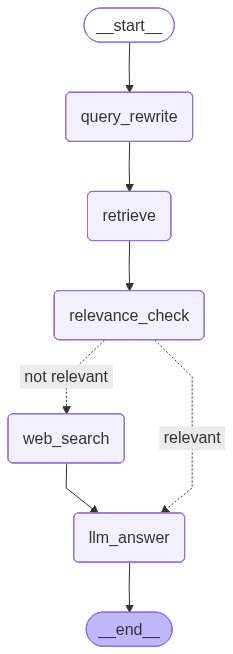

In [123]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


# 5. Graph Execution

In [ ]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid
from langchain_core.messages import HumanMessage

config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# Chunk 600 overlap 100
inputs = GraphState(question=[HumanMessage(content="What is DeepSeek-R1-Zero?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the DeepSeek-R1-Zero technology?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>Performance of DeepSeek-R1-Zero Figure 2 depicts the performance trajectory of DeepSeek-R1-Zero on the AIME 2024 benchmark throughout the RL training process. As illustrated, DeepSeek-R1-Zero demonstrates a steady and consistent enhancement in performance as the RL training advances. Notably, the average pass@1 score on AIME 2024 shows a significant increase, jumping from an initial 15.6% to an impressive 71.0%, reaching performance levels comparable to OpenAI-o1-0912. This significant improvement highlights the efficacy of our RL algorithm in optimizing the model’s performance over time.</content><source>data/Deepseek-r1.pdf</source><page>6</page></document>
<document><content># Self-evolution Process of DeepSeek-R1-Zero

The self-evolution process of DeepSeek-R1-Zero is a fascinating demonstration of how RL can drive a model to improve its reasoning capabilities autonomously. By initiat

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
DeepSeek-R1-Zero is a first-generation reasoning model trained solely via large-scale reinforcement learning (RL) without any supervised fine-tuning (SFT). It autonomously develops strong and sophisticated reasoning behaviors, significantly improving its performance on reasoning benchmarks like AIME 2024, where its pass@1 score rises from 15.6% to 71.0%, and further to 86.7% with majority voting, matching or exceeding models like OpenAI-o1-0912. The model naturally learns to allocate more thinking time and generate extensive reasoning tokens (hundreds to thousands) to solve complex tasks. However, it faces drawbacks such as poor readability and language mixing, which led to the development of DeepSeek-R1 with cold-start data and multi-stage training to address these issues.

**Source**  
- data/Deepseek-r1.pdf (pages 1, 3, 6, 7, 8, 9)
('user', 'What is the DeepSeek-R1-Zero technology?')
('assistant', 'Deep

In [ ]:
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# Chunk 300 overlap 50
inputs = GraphState(question=[HumanMessage(content="What is DeepSeek-R1-Zero?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the DeepSeek-R1-Zero technology?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>Performance of DeepSeek-R1-Zero Figure 2 depicts the performance trajectory of DeepSeek-R1-Zero on the AIME 2024 benchmark throughout the RL training process. As illustrated, DeepSeek-R1-Zero demonstrates a steady and consistent enhancement in performance as the RL training advances. Notably, the</content><source>data/Deepseek-r1.pdf</source><page>6</page></document>
<document><content>The self-evolution process of DeepSeek-R1-Zero is a fascinating demonstration of how RL can drive a model to improve its reasoning capabilities autonomously. By initiating RL directly from the base model, we can closely monitor the model’s progression without the influence of the supervised</content><source>data/Deepseek-r1.pdf</source><page>7</page></document>
<document><content>the performance of DeepSeek-R1-Zero can be further augmented through the application of majority voting. For example, when majori

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
DeepSeek-R1-Zero is a reinforcement learning (RL) based model designed to enhance reasoning capabilities of large language models (LLMs) without relying on cold-start data. It starts RL training directly from a base model using a simple template that guides it to produce a reasoning process followed by a final answer. Throughout training, it autonomously improves reasoning skills such as self-verification, reflection, and generating long chains of thought (CoTs). DeepSeek-R1-Zero shows significant performance gains on reasoning benchmarks like AIME 2024, improving pass@1 scores from 15.6% to 71.0%, and further to 86.7% with majority voting, surpassing some OpenAI models. It also exhibits emergent behaviors like an "aha moment" where it learns to rethink problems more deeply. However, it faces challenges like poor readability and language mixing, which are addressed in the subsequent DeepSeek-R1 model.

**S

In [124]:
# Chunk 600 overlap 100
inputs = GraphState(question=[HumanMessage(content="what is CeADAR, Ireland?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the CeADAR initiative in Ireland?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>of language mixing, we introduce a language consistency reward during RL training, which is calculated as the proportion of target language words in the CoT. Although ablation experiments show that such alignment results in a slight degradation in the model’s performance, this reward aligns with human preferences, making it more readable. Finally, we combine the accuracy of reasoning tasks and the reward for language consistency by directly summing them to form the final reward. We then apply RL training on the fine-tuned model until it achieves convergence on reasoning tasks.</content><source>data/Deepseek-r1.pdf</source><page>10</page></document>
<document><content>- Accuracy rewards: The accuracy reward model evaluates whether the response is correct. For example, in the case of math problems with deterministic results, the model is required to provide the final answer in a specified f

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: web_search 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<document><title>CeADAR Ireland</title><url>https://th.linkedin.com/company/ceadar-ireland?trk=ppro_cprof</url><content>CeADAR is Ireland's National Centre for AI. Funded by EI and the IDA, CeADAR has more than 90 member companies across a wide span of industries and is one</content></document>
<document><title>CeADAR</title><url>https://www.enterprise-ireland.com/en/supports/become-more-innovative/technology-centres/ceadar</url><content>CeADAR is the National Centre for Applied Artificial Intelligence and the European Digital Innovation Hub (EDIH) for AI in Ireland. CeADAR has more than 90 member companies ranging from multinationals to indigenous SMEs spanning every industry vertical. The primary work of the Centre is on cutting-edge applied AI innovation and developing and deploying industry prototypes and market-ready s

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
CeADAR is Ireland's National Centre for Applied Artificial Intelligence and the European Digital Innovation Hub (EDIH) for AI. It supports over 90 member companies across various industries by driving applied AI innovation, developing and deploying industry prototypes and market-ready AI solutions. CeADAR helps companies find funding, provides ecosystem networking in Ireland and Europe, offers training and access to a powerful in-house supercomputer, and assists in benchmarking AI maturity and strategy planning. It is one of only 9 Gold i-spaces in the EU, active in European projects, producing spinouts, and fostering a strong national AI innovation ecosystem.

**Source:**
- https://www.enterprise-ireland.com/en/supports/become-more-innovative/technology-centres/ceadar (full content)  
- https://www.clustercollaboration.eu/content/ceadar-irelands-centre-ai-and-applied-data-analytics
('user', 'What is the C

In [ ]:
# Chunk 300 overlap 50
inputs = GraphState(question=[HumanMessage(content="what is CeADAR, Ireland?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the CeADAR initiative in Ireland?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>In Section 3.2, we can see that by distilling DeepSeek-R1, the small model can achieve impressive results. However, there is still one question left: can the model achieve comparable performance through the large-scale RL training discussed in the paper without distillation?</content><source>data/Deepseek-r1.pdf</source><page>14</page></document>
<document><content>- Language Mixing: DeepSeek-R1 is currently optimized for Chinese and English, which may result in language mixing issues when handling queries in other languages. For instance, DeepSeek-R1 might use English for reasoning and responses, even if the query is in a language other than English or</content><source>data/Deepseek-r1.pdf</source><page>16</page></document>
<document><content>- Accuracy rewards: The accuracy reward model evaluates whether the response is correct. For example, in the case of math problems with determinist

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: web_search 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<document><title>CeADAR Ireland</title><url>https://th.linkedin.com/company/ceadar-ireland?trk=ppro_cprof</url><content>CeADAR is Ireland's National Centre for AI. Funded by EI and the IDA, CeADAR has more than 90 member companies across a wide span of industries and is one</content></document>
<document><title>CeADAR</title><url>https://www.enterprise-ireland.com/en/supports/become-more-innovative/technology-centres/ceadar</url><content>CeADAR is the National Centre for Applied Artificial Intelligence and the European Digital Innovation Hub (EDIH) for AI in Ireland. CeADAR has more than 90 member companies ranging from multinationals to indigenous SMEs spanning every industry vertical. The primary work of the Centre is on cutting-edge applied AI innovation and developing and deploying industry prototypes and market-ready s

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
CeADAR is Ireland's National Centre for Applied Artificial Intelligence and the European Digital Innovation Hub (EDIH) for AI. It supports over 90 member companies across various industries by driving applied AI innovation, developing and deploying industry prototypes and market-ready AI solutions. CeADAR helps companies find funding and investment, provides ecosystem networking in Ireland and Europe, offers training and access to a powerful in-house supercomputer, and assists members in benchmarking AI maturity and planning AI strategies. It is active in European projects, produces spinout companies, and is recognized as one of only 9 Gold i-spaces in the EU, having won national awards for AI strategy contributions. CeADAR also fosters a strong national AI innovation ecosystem and promotes good AI governance and trustworthy AI.

**Source**  
- https://www.enterprise-ireland.com/en/supports/become-more-inn

In [125]:
# Chunk 700 overlap 150
inputs = GraphState(question=[HumanMessage(content="What is value of QwQ-32B-Preview's AIME 2024 pass@1?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the AIME 2024 pass@1 value for QwQ-32B-Preview?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>pass@1 = 1 / k * Σ (pi), where pi denotes the correctness of the i-th response. This method provides more reliable performance estimates. For AIME 2024, we also report consensus (majority vote) results (Wang et al., 2022) using 64 samples, denoted as cons@64.

1https://aider.chat

2https://codeforces.com

3https://www.cms.org.cn/Home/comp/comp/cid/12.html</content><source>data/Deepseek-r1.pdf</source><page>12</page></document>
<document><content># Evaluation Setup

We set the maximum generation length to 32,768 tokens for the models. We found that using greedy decoding to evaluate long-output reasoning models results in higher repetition rates and significant variability across different checkpoints. Therefore, we default to pass@𝑘 evaluation (Chen et al., 2021) and report pass@1 using a non-zero temperature. Specifically, we use a sampling temperature of 0.6 and a top-𝑝 value of 0.95 to 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
The AIME 2024 pass@1 value for QwQ-32B-Preview is 50.0%.

**Source:**
- data/Deepseek-r1.pdf (page 14)
('user', 'What is the AIME 2024 pass@1 value for QwQ-32B-Preview?')
('assistant', 'The AIME 2024 pass@1 value for QwQ-32B-Preview is 50.0%.\n\n**Source:**\n- data/Deepseek-r1.pdf (page 14)')


In [ ]:
# Chunk 300 overlap 50
inputs = GraphState(question=[HumanMessage(content="What is value of QwQ-32B-Preview's AIME 2024 pass@1?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the pass@1 value for QwQ-32B-Preview's AIME 2024?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>the performance of DeepSeek-R1-Zero can be further augmented through the application of majority voting. For example, when majority voting is employed on the AIME benchmark, DeepSeek-R1-Zero’s performance escalates from 71.0% to 86.7%, thereby exceeding the performance of OpenAI-o1-0912. The</content><source>data/Deepseek-r1.pdf</source><page>7</page></document>
<document><content>AIME 2024 increases from 15.6% to 71.0%, and with majority voting, the score further improves to 86.7%, matching the performance of OpenAI-o1-0912.</content><source>data/Deepseek-r1.pdf</source><page>3</page></document>
<document><content>DeepSeek-R1-Distill-Qwen-7B achieves 55.5% on AIME 2024, surpassing QwQ-32B-Preview. Additionally, DeepSeek-R1-Distill-Qwen-32B scores 72.6% on AIME 2024, 94.3% on MATH-500, and 57.2% on LiveCodeBench. These results significantly outperform previous open-source models and are c

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
The pass@1 value for QwQ-32B-Preview on AIME 2024 is 39.2%.

**Source**  
- data/Deepseek-r1.pdf (page 13)
('user', "What is the pass@1 value for QwQ-32B-Preview's AIME 2024?")
('assistant', 'The pass@1 value for QwQ-32B-Preview on AIME 2024 is 39.2%.\n\n**Source**  \n- data/Deepseek-r1.pdf (page 13)')


In [57]:
# outputs = app.get_state(config).values
# outputs

## Difficult Question

In [126]:
inputs = GraphState(question=[HumanMessage(content="What is the main difference between DeepSeek-R1-Zero and DeepSeek-R1 in terms of training strategy?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What are the key differences in training strategies between DeepSeek-R1-Zero and DeepSeek-R1?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content># 2.3.1. Cold Start

Unlike DeepSeek-R1-Zero, to prevent the early unstable cold start phase of RL training from the base model, for DeepSeek-R1 we construct and collect a small amount of long CoT data to fine-tune the model as the initial RL actor. To collect such data, we have explored several approaches: using few-shot prompting with a long CoT as an example, directly prompting models to generate detailed answers with reflection and verification, gathering DeepSeek-R1-Zero outputs in a readable format, and refining the results through post-processing by human annotators.</content><source>data/Deepseek-r1.pdf</source><page>9</page></document>
<document><content>DeepSeek-R1 also delivers impressive results on IF-Eval, a benchmark designed to assess a model’s ability to follow format instructions. These improvements can be linked to the inclusion of instruction-following data during the f

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
The key differences in training strategies between DeepSeek-R1-Zero and DeepSeek-R1 are:

- **DeepSeek-R1-Zero** is trained via large-scale reinforcement learning (RL) directly from the base model without any supervised fine-tuning (SFT) or cold-start data. It naturally learns reasoning capabilities through RL alone but suffers from issues like poor readability and language mixing.

- **DeepSeek-R1** incorporates a multi-stage training pipeline including a cold-start phase before RL. This involves collecting a small amount of long chain-of-thought (CoT) data to fine-tune the base model initially, using methods like few-shot prompting, direct prompting for detailed answers, and human-annotated refinements. After this cold start, reasoning-oriented RL is applied, followed by additional supervised fine-tuning using rejection sampling on RL checkpoints combined with supervised data in domains like writing and 

In [127]:
inputs = GraphState(question=[HumanMessage(content="What is GRPO (Group Relative Policy Optimization), and why is it used in DeepSeek-R1-Zero?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is Group Relative Policy Optimization (GRPO), and what is its purpose in DeepSeek-R1-Zero?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>However, DeepSeek-R1-Zero encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates a small amount of cold-start data and a multi-stage training pipeline. Specifically, we begin by collecting thousands of cold-start data to fine-tune the DeepSeek-V3-Base model. Following this, we perform reasoning-oriented RL like DeepSeek-R1-Zero. Upon nearing convergence in the RL process, we create new SFT data through rejection sampling on the RL checkpoint, combined with supervised data from DeepSeek-V3 in domains such as writing, factual QA, and self-cognition, and then retrain</content><source>data/Deepseek-r1.pdf</source><page>3</page></document>
<document><content>DeepSeek-R1-Zero to attain robust reasoning capabilities without the need for any supervised fine-tuning data. Th

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
Group Relative Policy Optimization (GRPO) is a reinforcement learning algorithm used in DeepSeek-R1-Zero to reduce training costs by eliminating the need for a separate critic model. Instead, GRPO estimates the baseline from group scores by sampling a group of outputs from the old policy and optimizing the policy model to maximize a clipped objective with a KL divergence penalty relative to a reference policy. Its purpose in DeepSeek-R1-Zero is to efficiently train the model via large-scale RL, enabling it to develop robust reasoning capabilities without supervised fine-tuning.

**Source:**
- data/Deepseek-r1.pdf (page 5)
('user', 'What is Group Relative Policy Optimization (GRPO), and what is its purpose in DeepSeek-R1-Zero?')
('assistant', 'Group Relative Policy Optimization (GRPO) is a reinforcement learning algorithm used in DeepSeek-R1-Zero to reduce training costs by eliminating the need for a separa

In [128]:
inputs = GraphState(question=[HumanMessage(content="What two types of rewards are used to train DeepSeek-R1-Zero, and what is their purpose?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What are the two types of rewards used in training DeepSeek-R1-Zero, and what purposes do they serve?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>We do not apply the outcome or process neural reward model in developing DeepSeek-R1-Zero, because we find that the neural reward model may suffer from reward hacking in the large-scale reinforcement learning process, and retraining the reward model needs additional training resources and it complicates the whole training pipeline.

# 2.2.3. Training Template</content><source>data/Deepseek-r1.pdf</source><page>6</page></document>
<document><content># 2.3.1. Cold Start

Unlike DeepSeek-R1-Zero, to prevent the early unstable cold start phase of RL training from the base model, for DeepSeek-R1 we construct and collect a small amount of long CoT data to fine-tune the model as the initial RL actor. To collect such data, we have explored several approaches: using few-shot prompting with a long CoT as an example, directly prompting models to generate detailed answers with reflection and verifica

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: web_search 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<document><title>DeepSeek-R1: Incentivizing Reasoning Capability in LLMs ...</title><url>https://arxiv.org/pdf/2501.12948</url><content>by D Guo · 2025 · Cited by 5616 — To train DeepSeek-R1-Zero, we adopt a rule-based reward system that mainly consists of two types of rewards: • Accuracy rewards: The</content><raw>DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning DeepSeek-AI research@deepseek.com Abstract We introduce our first-generation reasoning models, DeepSeek-R1-Zero and DeepSeek-R1.
DeepSeek-R1-Zero, a model trained via large-scale reinforcement learning (RL) without super-vised fine-tuning (SFT) as a preliminary step, demonstrates remarkable reasoning capabilities.
Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing reasoning behaviors. However, it e

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
The two types of rewards used in training DeepSeek-R1-Zero are:

1. **Accuracy Rewards**: These evaluate whether the model's response is correct. For example, in math problems, the final answer must be in a specified format to allow rule-based verification. For coding problems like LeetCode, a compiler runs predefined test cases to provide feedback.

2. **Format Rewards**: These enforce the model to output its reasoning process enclosed between `<think>` and `</think>` tags, ensuring the reasoning steps are clearly structured.

These rewards guide the reinforcement learning process by incentivizing correctness and structured reasoning without using neural reward models, which were avoided to prevent reward hacking and reduce training complexity.

**Source:**
- data/Deepseek-r1.pdf (pages 5-6)
('user', 'What are the two types of rewards used in training DeepSeek-R1-Zero, and what purposes do they serve?')
(

In [129]:
inputs = GraphState(question=[HumanMessage(content="What Pass@1 performance does DeepSeek-R1 achieve on AIME 2024 and MATH-500?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

What is the Pass@1 performance of DeepSeek-R1 on the AIME 2024 and MATH-500 datasets?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>DeepSeek-R1 also delivers impressive results on IF-Eval, a benchmark designed to assess a model’s ability to follow format instructions. These improvements can be linked to the inclusion of instruction-following data during the final stages of supervised fine-tuning (SFT) and RL training. Furthermore, remarkable performance is observed on AlpacaEval2.0 and ArenaHard, indicating DeepSeek-R1’s strengths in writing tasks and open-domain question answering. Its significant outperformance of DeepSeek-V3 underscores the generalization benefits of large-scale RL, which not only boosts reasoning capabilities but also improves performance across diverse domains. Moreover, the summary lengths</content><source>data/Deepseek-r1.pdf</source><page>13</page></document>
<document><content>On math tasks, DeepSeek-R1 demonstrates performance on par with OpenAI-o1-1217, surpassing other models by a large ma

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
The Pass@1 performance of DeepSeek-R1 is:

- **AIME 2024:** 72.6%
- **MATH-500:** 94.3%

**Source:**
- data/Deepseek-r1.pdf (page 4)
('user', 'What is the Pass@1 performance of DeepSeek-R1 on the AIME 2024 and MATH-500 datasets?')
('assistant', 'The Pass@1 performance of DeepSeek-R1 is:\n\n- **AIME 2024:** 72.6%\n- **MATH-500:** 94.3%\n\n**Source:**\n- data/Deepseek-r1.pdf (page 4)')


In [130]:
inputs = GraphState(question=[HumanMessage(content="How does distillation from DeepSeek-R1 improve the performance of smaller models such as Qwen-7B or Qwen-32B?")])
invoke_graph(app, inputs, config)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================

In what ways does distillation from DeepSeek-R1 enhance the performance of smaller models like Qwen-7B and Qwen-32B?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"



🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>However, DeepSeek-R1-Zero encounters challenges such as poor readability, and language mixing. To address these issues and further enhance reasoning performance, we introduce DeepSeek-R1, which incorporates a small amount of cold-start data and a multi-stage training pipeline. Specifically, we begin by collecting thousands of cold-start data to fine-tune the DeepSeek-V3-Base model. Following this, we perform reasoning-oriented RL like DeepSeek-R1-Zero. Upon nearing convergence in the RL process, we create new SFT data through rejection sampling on the RL checkpoint, combined with supervised data from DeepSeek-V3 in domains such as writing, factual QA, and self-cognition, and then retrain</content><source>data/Deepseek-r1.pdf</source><page>3</page></document>
<document><content>As shown in Table 5, simply distilling DeepSeek-R1’s outputs enables the efficient DeepSeek-R1-7B (i.e., DeepSeek

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
Distillation from DeepSeek-R1 enhances smaller models like Qwen-7B and Qwen-32B by transferring the advanced reasoning patterns learned by the larger DeepSeek-R1 model. This results in significantly improved performance on reasoning benchmarks compared to models trained solely with large-scale RL or non-reasoning baselines. For example, DeepSeek-R1-Distill-Qwen-7B achieves 55.5% on AIME 2024, surpassing QwQ-32B-Preview, while DeepSeek-R1-Distill-Qwen-32B scores 72.6% on AIME 2024 and 94.3% on MATH-500, outperforming previous open-source models and matching or exceeding larger models. Distillation is more computationally efficient and yields better results than RL training on smaller models, highlighting the importance of leveraging reasoning capabilities from powerful base models.

**Source:**
- data/Deepseek-r1.pdf (pages 3, 4, 14, 15)
('user', 'In what ways does distillation from DeepSeek-R1 enhance the 